In [16]:
pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer

# 1. Load the IMDb dataset
#    This will give you two splits: 'train' (25 000 examples) and 'test' (25 000 examples).
raw_datasets = load_dataset("imdb")  # :contentReference[oaicite:0]{index=0}&#8203;:contentReference[oaicite:1]{index=1}

# If you want exactly 3 000 train and 2 000 test samples:
train_ds = raw_datasets["train"].shuffle(seed=42).select(range(3000))
test_ds  = raw_datasets["test"].shuffle(seed=42).select(range(2000))

# 2. Load the RoBERTa-Base tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")  # :contentReference[oaicite:2]{index=2}

# 3. Define a tokenization function with padding & truncation
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],               # field name in IMDb dataset
        padding="max_length",        # pad all samples to `max_length`
        truncation=True,             # truncate longer ones
        max_length=256               # you can adjust this as needed
    )  # :contentReference[oaicite:3]{index=3}

# Apply it in batched mode for speed
tokenized_train = train_ds.map(tokenize_fn, batched=True)
tokenized_test  = test_ds.map(tokenize_fn, batched=True)

# Optional: set format for PyTorch / TensorFlow
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch",  columns=["input_ids", "attention_mask", "label"])

In [19]:
pip install tf-keras

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install hf_xet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install --upgrade transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install transformers[torch]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install accelerate>=0.26.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from sklearn.metrics import accuracy_score
import torch
import time

# 1. Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=2
)

# 2. Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 3. Training args
training_args = TrainingArguments(
    output_dir="./full_ft",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    eval_steps=50,
    save_strategy="no",
)

# 4. Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

# 5. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 6. Parameter count
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_params(model):,}")

# 7. GPU usage before training
def print_gpu_usage(stage=""):
    allocated = torch.cuda.memory_allocated() / (1024**3)
    reserved  = torch.cuda.memory_reserved()  / (1024**3)
    print(f"[{stage}] GPU allocated: {allocated:.2f} GiB; reserved: {reserved:.2f} GiB")

print_gpu_usage("Before training")

# 8. Training time measurement
start_time = time.time()
train_output = trainer.train()
elapsed = time.time() - start_time
print(f"Total training time (s): {elapsed:.2f}")

# 9. GPU usage after training
print_gpu_usage("After training")

# 10. Final accuracy on test set
metrics = trainer.evaluate(tokenized_test)
print(f"Test accuracy: {metrics['eval_accuracy']:.4f}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_43670/4159630744.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainable parameters: 124,647,170
[Before training] GPU allocated: 0.47 GiB; reserved: 0.52 GiB


Step,Training Loss
50,0.607000
100,0.440700
150,0.405200
200,0.318500
250,0.418000
300,0.446400
350,0.376500
400,0.313500
450,0.265600
500,0.213200


Total training time (s): 207.30
[After training] GPU allocated: 1.41 GiB; reserved: 3.11 GiB


Test accuracy: 0.9160


In [25]:
pip install peft

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.metrics import accuracy_score
import torch
import time

# 1. Compute‐metrics callback (unchanged)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

# 2. Count only the LoRA parameters (optional) or all trainable params
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"LoRA trainable parameters: {count_params(model):,}")

# 3. GPU‐usage helper
def print_gpu_usage(stage=""):
    allocated = torch.cuda.memory_allocated() / (1024**3)
    reserved  = torch.cuda.memory_reserved()  / (1024**3)
    print(f"[{stage}] GPU allocated: {allocated:.2f} GiB; reserved: {reserved:.2f} GiB")

# 4. Before training
print_gpu_usage("Before LoRA training")

# 5. Time the training call
start_time = time.time()
train_output = trainer.train()
elapsed = time.time() - start_time

print(f"Total LoRA training time (s): {elapsed:.2f}")
print_gpu_usage("After LoRA training")

# 6. Final evaluation & accuracy
metrics = trainer.evaluate(tokenized_test)
print(f"LoRA test accuracy: {metrics['eval_accuracy']:.4f}")

LoRA trainable parameters: 124,647,170
[Before LoRA training] GPU allocated: 1.41 GiB; reserved: 3.11 GiB


Step,Training Loss
50,0.206500
100,0.119600
150,0.164000
200,0.094000
250,0.157400
300,0.212800
350,0.245300
400,0.146200
450,0.069400
500,0.023100


Total LoRA training time (s): 214.27
[After LoRA training] GPU allocated: 1.41 GiB; reserved: 3.10 GiB
LoRA test accuracy: 0.9065


In [3]:
pip install --upgrade bitsandbytes

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install -U bitsandbytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [4]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, TaskType
import torch
import time
from sklearn.metrics import accuracy_score

# 1. Load and tokenize dataset
raw_datasets = load_dataset('imdb')
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def preprocess(batch):
    tokens = tokenizer(
        batch['text'],
        truncation=True,
        padding='max_length',
        max_length=256
    )
    tokens['labels'] = batch['label']
    return tokens

tokenized = raw_datasets.map(
    preprocess,
    batched=True,
    remove_columns=raw_datasets['train'].column_names
)

train_dataset = tokenized['train'].shuffle(seed=42).select(range(3000))
test_dataset  = tokenized['test'].shuffle(seed=42).select(range(2000))

# 2. Model initialization with QLoRA + LoRA adapters
def init_model_with_lora(
    base_model='roberta-base',
    num_labels=2,
    lora_r=16,
    lora_alpha=32,
    lora_dropout=0.05
):
    # Try 8-bit quantization if possible
    try:
        model = AutoModelForSequenceClassification.from_pretrained(
            base_model,
            num_labels=num_labels,
            load_in_8bit=True,
            device_map='auto'
        )
    except Exception:
        model = AutoModelForSequenceClassification.from_pretrained(
            base_model,
            num_labels=num_labels
        )
        if torch.cuda.is_available():
            model = model.cuda()

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Attach LoRA adapters
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=['query', 'key', 'value'],
        bias='none'
    )
    model = get_peft_model(model, lora_config)
    return model

model = init_model_with_lora()

# 3. Report trainable vs total parameters
def count_trainable_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable params: {trainable:,} | Total params: {total:,} | "
          f"Trainable%: {100 * trainable / total:.2f}%")

count_trainable_parameters(model)

# 4. Training arguments
training_args = TrainingArguments(
    output_dir='./qLoRA-roberta-base',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-4,
    logging_steps=50,
    logging_strategy='steps',
    eval_strategy='epoch',
    save_strategy='epoch',
    fp16=True,
    load_best_model_at_end=True,
    weight_decay=0.01,
    remove_unused_columns=False,
    metric_for_best_model='accuracy'
)

data_collator = DataCollatorWithPadding(tokenizer)

# 5. Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {'accuracy': accuracy_score(labels, preds)}

# 6. GPU memory helper
def print_gpu_memory_usage(stage):
    alloc = torch.cuda.memory_allocated() / (1024**3)
    reserved = torch.cuda.memory_reserved()  / (1024**3)
    print(f"[{stage}] GPU allocated: {alloc:.2f} GB | reserved: {reserved:.2f} GB")

# 7. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 8. Measure GPU usage (before), training time, and GPU usage (after)
print_gpu_memory_usage("Before training")

start_time = time.time()
train_result = trainer.train()
total_time = time.time() - start_time

print(f"Total training time (s): {total_time:.2f}")

print_gpu_memory_usage("After training")

# 9. Final evaluation on test set
metrics = trainer.evaluate(test_dataset)
print(f"Test Accuracy: {metrics['eval_accuracy']:.4f}")

# 10. Save LoRA adapter weights
trainer.model.save_pretrained('./qLoRA-roberta-base-adapter')
print("QLoRA fine-tuning completed and adapter saved.")

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_43670/3932846919.py:122: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list w

Trainable params: 1,476,866 | Total params: 126,124,036 | Trainable%: 1.17%
[Before training] GPU allocated: 0.49 GB | reserved: 3.10 GB


Epoch,Training Loss,Validation Loss,Accuracy
1,0.304400,0.211078,0.914500
2,0.251700,0.209566,0.919500
3,0.248000,0.254105,0.920500


Total training time (s): 70.36
[After training] GPU allocated: 0.50 GB | reserved: 1.43 GB


Test Accuracy: 0.9205
QLoRA fine-tuning completed and adapter saved.


In [9]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from peft import IA3Config, get_peft_model, TaskType
import torch
import time
from sklearn.metrics import accuracy_score

# 0. Load raw datasets
raw_train = load_dataset("imdb", split="train")
raw_test  = load_dataset("imdb", split="test")

# 1. Tokenizer & base model (frozen until wrapped)
model_name = "roberta-base"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

# 2. IA³ configuration using correct target module names
ia3_config = IA3Config(
    task_type=TaskType.SEQ_CLS,
    target_modules=["query", "key", "value", "output.dense"],
    feedforward_modules=["output.dense"],
    fan_in_fan_out=False,
    init_ia3_weights=True
)

# 3. Apply IA³ to the base model
model = get_peft_model(base_model, ia3_config)

# 4. Tokenize datasets
def tokenize_fn(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_train = raw_train.map(tokenize_fn, batched=True)
tokenized_test  = raw_test.map(tokenize_fn, batched=True)

# 5. Data collator
data_collator = DataCollatorWithPadding(tokenizer)

# 6. Count parameters
def count_trainable_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable params: {trainable:,} | Total params: {total:,} | "
          f"Trainable%: {100 * trainable / total:.2f}%")

count_trainable_parameters(model)

# 7. Training arguments
training_args = TrainingArguments(
    output_dir="./ia3_ft",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="steps",
    eval_steps=500,
    logging_steps=100,
    save_steps=1000,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    weight_decay=0.01,
    fp16=True
)

# 8. Accuracy metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

# 9. GPU usage logging
def print_gpu_memory_usage(stage):
    if torch.cuda.is_available():
        alloc    = torch.cuda.memory_allocated() / (1024**3)
        reserved = torch.cuda.memory_reserved()  / (1024**3)
        print(f"[{stage}] GPU allocated: {alloc:.2f} GB | reserved: {reserved:.2f} GB")

# 10. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 11. Run training with memory tracking
print_gpu_memory_usage("Before training")
start_time = time.time()
train_result = trainer.train()
training_time = time.time() - start_time
print(f"Total training time (s): {training_time:.2f}")
print_gpu_memory_usage("After training")

# 12. Evaluate on test set
metrics = trainer.evaluate(tokenized_test)
print(f"Test Accuracy: {metrics['eval_accuracy']:.4f}")

# 13. Save IA³ adapter
trainer.model.save_pretrained("./ia3-roberta-base-adapter")
print("IA³ fine-tuning complete. Adapter weights saved.")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_43670/1405970114.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 665,858 | Total params: 125,313,028 | Trainable%: 0.53%
[Before training] GPU allocated: 1.49 GB | reserved: 2.53 GB


Step,Training Loss,Validation Loss,Accuracy
500,0.617500,0.599301,0.815280
1000,0.412900,0.384313,0.842080
1500,0.372900,0.338051,0.853720
2000,0.358600,0.326793,0.859320
2500,0.327700,0.320154,0.863400
3000,0.376900,0.314860,0.866120
3500,0.351500,0.311907,0.867560
4000,0.347300,0.309613,0.868600
4500,0.347900,0.309645,0.868240


Total training time (s): 558.54
[After training] GPU allocated: 1.00 GB | reserved: 2.35 GB


Test Accuracy: 0.8686
IA³ fine-tuning complete. Adapter weights saved.


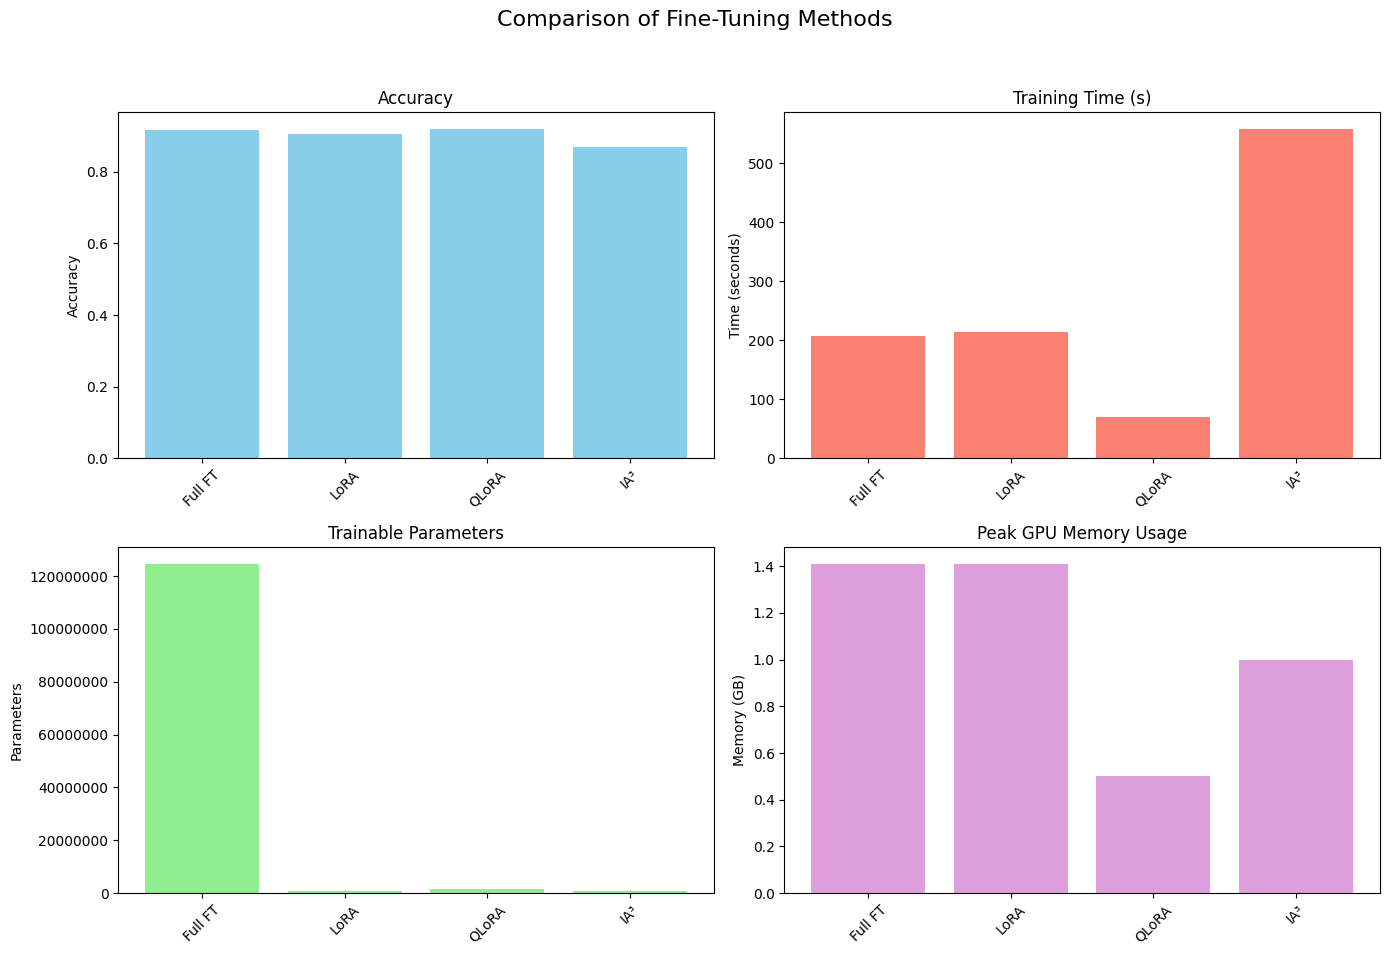

In [11]:
import matplotlib.pyplot as plt

# Define the data
methods = ['Full FT', 'LoRA', 'QLoRA', 'IA³']
accuracy = [0.9160, 0.9065, 0.9205, 0.8686]
training_time = [207.30, 214.27, 70.36, 558.54]  # in seconds
trainable_params = [124_647_170, 887_042, 1_476_866, 665_858]
gpu_memory = [1.41, 1.41, 0.50, 1.00]  # in GB

# Plotting setup
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Comparison of Fine-Tuning Methods", fontsize=16)

# Accuracy
axs[0, 0].bar(methods, accuracy, color='skyblue')
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_ylabel("Accuracy")

# Training time
axs[0, 1].bar(methods, training_time, color='salmon')
axs[0, 1].set_title("Training Time (s)")
axs[0, 1].set_ylabel("Time (seconds)")

# Trainable parameters
axs[1, 0].bar(methods, trainable_params, color='lightgreen')
axs[1, 0].set_title("Trainable Parameters")
axs[1, 0].set_ylabel("Parameters")
axs[1, 0].ticklabel_format(style='plain', axis='y')  # Prevent scientific notation

# GPU memory
axs[1, 1].bar(methods, gpu_memory, color='plum')
axs[1, 1].set_title("Peak GPU Memory Usage")
axs[1, 1].set_ylabel("Memory (GB)")

# Rotate x labels for clarity
for ax in axs.flat:
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
